# Sélection des variables du jeu de données DVF+ - Appartements à Paris

**Méthode**
- Application des filtres statiques sur les variables DVF
- Ajout des variables spatio-temporelles du prix du marché
- Train/test split temporel
- `RandomForestRegressor()`
- Importance des variables $\rightarrow$ sélection des variables importantes

## Setup

In [2]:
import sys
sys.path.append("../")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd 
import numpy as np 

from tqdm import tqdm 

import seaborn as sns 
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter

import statsmodels.api as sm

from sklearn.model_selection import train_test_split

import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from sklearn.metrics import (
    mean_absolute_error, 
    mean_absolute_percentage_error,
    mean_squared_error,  
    r2_score, 
    make_scorer
)

from sklearn.feature_selection import mutual_info_regression

In [5]:
import gc 
gc.collect()

0

In [6]:
pd.set_option("display.max_columns", None)

In [7]:
DATA_DIR = "../data/"
ZIP_DIR = f"{DATA_DIR}dvf_cleaned.zip" 

## Data preprocessing

In [8]:
df = pd.read_csv(f"{DATA_DIR}dvfplus_paris_flats.csv")

c:\Users\pemma\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (8,18,20,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
df.shape

(160757, 86)

In [10]:
list(df.columns)

['id_mutation',
 'date_mutation',
 'numero_disposition',
 'nature_mutation',
 'valeur_fonciere',
 'adresse_numero',
 'adresse_suffixe',
 'adresse_nom_voie',
 'adresse_code_voie',
 'code_postal',
 'code_commune',
 'nom_commune',
 'code_departement',
 'ancien_code_commune',
 'ancien_nom_commune',
 'id_parcelle',
 'ancien_id_parcelle',
 'numero_volume',
 'lot1_numero',
 'lot1_surface_carrez',
 'lot2_numero',
 'lot2_surface_carrez',
 'lot3_numero',
 'lot3_surface_carrez',
 'lot4_numero',
 'lot4_surface_carrez',
 'lot5_numero',
 'lot5_surface_carrez',
 'nombre_lots',
 'code_type_local',
 'type_local',
 'surface_reelle_bati',
 'nombre_pieces_principales',
 'code_nature_culture',
 'nature_culture',
 'code_nature_culture_speciale',
 'nature_culture_speciale',
 'surface_terrain',
 'longitude',
 'latitude',
 'dependance',
 'code_region',
 'nom_departement',
 'nom_region',
 'degre_densite',
 'pop',
 'annee',
 'trimestre',
 'mois',
 'jour',
 'parcelle_id',
 'code_iris',
 'periode_construction',
 '

In [11]:
DVF_VARS = [
    "id_mutation",
    "date_mutation",
    "valeur_fonciere",
    "nom_commune",
    "surface_reelle_bati",
    "nombre_pieces_principales",
    "surface_terrain",
    "dependance",
    "annee",
    "trimestre",
    "mois",
    "jour" 
]

BNB_VARS = [
    "parcelle_id",
    "code_iris",
    "periode_construction",
    "periode_construction_max",
    "hauteur_mean",
    "altitude_sol_mean",
    "conso_ener_mean",
    "estim_ges_mean",
    "conso_ener_min",
    "estim_ges_min",
    "conso_ener_max",
    "estim_ges_max",
    "enr_solaire_photovoltaique",
    "enr_solaire_thermique_(chauffage)solaire_thermique_(ecs)",
    "enr_solaire_thermique_(ecs+chauffage)",
    "mur_pos_isol_ext",
    "presence_climatisation",
    "baie_orientation_indetermine",
    "baie_orientation_nord",
    "baie_orientation_ouest",
    "baie_orientation_est",
    "baie_orientation_horizontale",
    "baie_orientation_est_ou_ouest",
    "baie_orientation_sud",
    "distance_batiment_historique_plus_proche",
    "nom_batiment_historique_plus_proche",
    "qpv",
    "nb_lot_garpark",
    "nb_lot_tot",
    "nb_log",
    "nb_lot_tertiaire",
    "alea_argiles",
    "alea_radon"
]

In [12]:
df = df[DVF_VARS+BNB_VARS]

### Suppression colonnes `NA`

In [13]:
from pandas.core.frame import DataFrame
from typing import Tuple

def get_na_proportion(df: DataFrame, col: str) -> float:
    
    return df[col].isna().sum() / df.shape[0]

def remove_na_cols(df: DataFrame, threshold: float) -> Tuple:
    
    na_cols = [col for col in df.columns if get_na_proportion(df, col) > threshold]
    df = df.drop(na_cols, axis=1)
    
    return df, na_cols

In [14]:
df, na_cols = remove_na_cols(df, threshold=.2)

In [15]:
na_cols

['surface_terrain', 'alea_argiles']

In [16]:
for col in na_cols: 
    
    if col in DVF_VARS: 
        DVF_VARS.remove(col)
    elif col in BNB_VARS: 
        BNB_VARS.remove(col)

In [17]:
df.shape

(160757, 43)

### Filtres statiques

A partir des variables DVF.

#### Nombre de pièces principales

In [18]:
df.nombre_pieces_principales.value_counts()

2.0     54848
1.0     42061
3.0     36110
4.0     16434
5.0      7127
6.0      2551
7.0       969
8.0       299
0.0       196
9.0        75
10.0       47
11.0       17
12.0        6
13.0        3
17.0        2
16.0        2
20.0        2
22.0        1
21.0        1
19.0        1
23.0        1
26.0        1
14.0        1
15.0        1
Name: nombre_pieces_principales, dtype: int64

In [19]:
def filter_df(df: DataFrame, var_name: str, interval: Tuple) -> DataFrame:

        min_val, max_val = interval
        mask = (df[var_name] >= min_val) & (df[var_name] <= max_val)
        return df[mask]

In [20]:
df = filter_df(df, "nombre_pieces_principales", interval=(1, 6))  
df.shape

(159131, 43)

#### Surface habitable

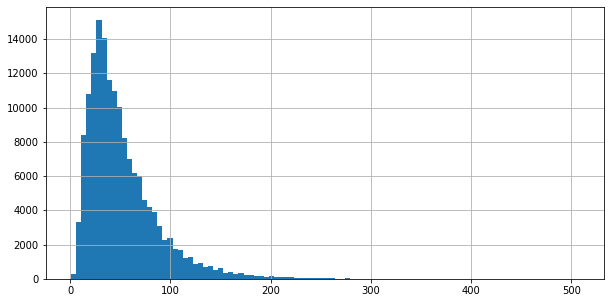

In [21]:
df.surface_reelle_bati.hist(figsize=(10, 5), bins=100); 

In [22]:
df = filter_df(df, "surface_reelle_bati", interval=(9, 200))  
df.shape

(157274, 43)

In [23]:
df["l_surface_reelle_bati"] = np.log(df.surface_reelle_bati)

#### Prix/m²

In [24]:
from typing import Optional

def transform_price(price: float, log:bool, area: Optional[float]=None) -> float: 

    y = price

    if area != None: 
        y = y / area

    if log: 
        y = np.log(y)
    
    return y 

In [25]:
df["valeur_fonciere_m2"] = df.apply(lambda row: transform_price(row.valeur_fonciere, False, row.surface_reelle_bati), axis=1) 
df["l_valeur_fonciere"] = df.apply(lambda row: transform_price(row.valeur_fonciere, True), axis=1) 

DVF_VARS.append("valeur_fonciere_m2")
DVF_VARS.append("l_valeur_fonciere")

D"après l"estimation faite par [meilleursagents](https://www.meilleursagents.com/prix-immobilier/paris-75000/), le prix/m² des appartements à Paris peut valoir entre de 6 847 € à 16 324 €. Afin d"être moins restrictif et pour prendre en compte les éventuelles fluctuations, on décide de sélectionner les biens tq $\text{valeur\_fonciere\_m2} \in [5 000, 20 000]$.

In [26]:
df = filter_df(df, "valeur_fonciere_m2", interval=(5000, 20000))
df.shape

(146188, 46)

### Ajout de variables DVF

#### Arrondissements

In [27]:
DIGIT = r"[0-9]+"
import re

def extract_int_from_string(string: str) -> int: 
    integer = re.findall(DIGIT, string)

    if len(integer) > 1: 
        raise ValueError("Multiple integers found.")
    
    return integer[0]

In [28]:
df["arrondissement"] = df.nom_commune.apply(extract_int_from_string)
DVF_VARS.append("arrondissement")

#### Moyennes mobiles par quartier

L"objectif est de construire des variables permettant de prendre en compte l"évolution des prix du marché par arrondissement. Les moyennes mobiles sont un outil pertinent pour le faire. 

1. Aggrégation journalière (moyenne) des valeurs foncières par arrondissement
2. Appliquation d"un lag de 1 jour sur les valeurs agrégées par arrondissement
3. Moyenne mobile sur $k$ jours appliquée aux valeurs agrégées décalées par arrondissement

In [29]:
from pandas.core.frame import DataFrame
from typing import Optional

def calc_movav_prices(
    df: DataFrame, 
    window_size: int, 
    lag: int=1, 
    price_var: str="valeur_fonciere", 
    date_var: str="date_mutation", 
    neighborhood_var: Optional[str]="arrondissement"
) -> DataFrame: 
    """Description. Compute moving average prices per neighborhood.""" 

    if neighborhood_var != None: 
        by = [neighborhood_var, date_var]
    else:
        by = date_var

    avg_prices = df\
        .groupby(by)\
        [price_var]\
        .mean()\
        .shift(lag)

    if neighborhood_var != None: 
        avg_prices = avg_prices.groupby(neighborhood_var)

    mov_avg_prices = avg_prices\
        .apply(lambda x: x.rolling(window_size).mean())\
        .reset_index()\
        .rename(columns={price_var: f"{price_var}_ma{window_size}"})

    return mov_avg_prices

def add_movav_prices(
    df: DataFrame, 
    mov_av_prices: DataFrame, 
    date_var: str="date_mutation", 
    neighborhood_var: Optional[str]="arrondissement"
) -> DataFrame: 
    """Description. Merge moving average prices and DVF dataset."""

    keys = []
    if neighborhood_var != None: 
        keys.append(neighborhood_var) 
        
    keys.append(date_var)

    new_df = pd.merge(
        left=df, 
        right=mov_av_prices, 
        how="left", 
        left_on=keys, 
        right_on=keys)
    
    return new_df

def shift_movav_prices(df: DataFrame, lag: int) -> DataFrame: 
    """Description. Add n-day lag to moving average prices."""

    cols = df.columns[df.columns.str.contains("_ma")].tolist()
    df.loc[:, cols] = df[cols].apply(lambda x: x.shift(lag))

    return df

In [30]:
# keep trace of moving average prices
mov_av_prices = {}

for window_size in (7, 14, 30, 90): 
    # calculate lagged moving average prices (lag=1)
    mov_av_prices[window_size] = calc_movav_prices(df, window_size, lag=1)

    # add to dvf
    df = add_movav_prices(df, mov_av_prices[window_size]) 

In [31]:
# add logaritmic moving average prices

ma_vars = [
    "valeur_fonciere_ma7",
    "valeur_fonciere_ma14",
    "valeur_fonciere_ma30",
    "valeur_fonciere_ma90"
]

for var in ma_vars: 
    df[f"l_{var}"] = df[var].apply(lambda x: np.log(x))

In [32]:
for var in ma_vars: 
    DVF_VARS.append(var)
    DVF_VARS.append(f"l_{var}")

### Variables Base Nationale des Batiments

In [33]:
BNB_VARS

['parcelle_id',
 'code_iris',
 'periode_construction',
 'periode_construction_max',
 'hauteur_mean',
 'altitude_sol_mean',
 'conso_ener_mean',
 'estim_ges_mean',
 'conso_ener_min',
 'estim_ges_min',
 'conso_ener_max',
 'estim_ges_max',
 'enr_solaire_photovoltaique',
 'enr_solaire_thermique_(chauffage)solaire_thermique_(ecs)',
 'enr_solaire_thermique_(ecs+chauffage)',
 'mur_pos_isol_ext',
 'presence_climatisation',
 'baie_orientation_indetermine',
 'baie_orientation_nord',
 'baie_orientation_ouest',
 'baie_orientation_est',
 'baie_orientation_horizontale',
 'baie_orientation_est_ou_ouest',
 'baie_orientation_sud',
 'distance_batiment_historique_plus_proche',
 'nom_batiment_historique_plus_proche',
 'qpv',
 'nb_lot_garpark',
 'nb_lot_tot',
 'nb_log',
 'nb_lot_tertiaire',
 'alea_radon']

In [34]:
BNB_QUANT_VARS = [  
    "hauteur_mean",
    "altitude_sol_mean",
    "conso_ener_mean",
    "estim_ges_mean",
    "conso_ener_min",
    "estim_ges_min",
    "conso_ener_max",
    "estim_ges_max",
    "distance_batiment_historique_plus_proche",
    "nb_lot_garpark",
    "nb_lot_tot",
    "nb_log",
    "nb_lot_tertiaire"
]

#### Variables quantitatives

In [35]:
# apply logarithm to continuous variables
for col in [
    "hauteur_mean",
    "altitude_sol_mean",
    "conso_ener_mean",
    "estim_ges_mean",
    "conso_ener_min",
    "estim_ges_min",
    "conso_ener_max",
    "estim_ges_max",
    "distance_batiment_historique_plus_proche",
]: 
    var_name = f"l_{col}"
    df.loc[:, var_name] = np.log(df[col])
    BNB_QUANT_VARS.append(var_name)
    BNB_VARS.append(var_name)

# convert inf values with nan
df = df.replace([np.inf, -np.inf], np.nan)

c:\Users\pemma\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Variables catégorielles

In [36]:
def get_unique_values(df: DataFrame, col: str) -> list: 
    unique_values = [
        val 
        for val in df[col].unique().tolist()
        if val == val 
    ]

    return unique_values

def get_cols_with_one_value(df: DataFrame, cols: list) -> DataFrame: 

    unique_cols = [
        col for col in cols
        if len(get_unique_values(df, col)) == 1
    ]

    return unique_cols

In [37]:
to_remove = get_cols_with_one_value(df, BNB_VARS)
df = df.drop(labels=to_remove, axis=1)

for col in to_remove:
    BNB_VARS.remove(col)

In [38]:
BNB_VARS

['parcelle_id',
 'code_iris',
 'periode_construction',
 'periode_construction_max',
 'hauteur_mean',
 'altitude_sol_mean',
 'conso_ener_mean',
 'estim_ges_mean',
 'conso_ener_min',
 'estim_ges_min',
 'conso_ener_max',
 'estim_ges_max',
 'enr_solaire_photovoltaique',
 'mur_pos_isol_ext',
 'presence_climatisation',
 'baie_orientation_indetermine',
 'baie_orientation_nord',
 'baie_orientation_ouest',
 'baie_orientation_est',
 'baie_orientation_horizontale',
 'baie_orientation_est_ou_ouest',
 'baie_orientation_sud',
 'distance_batiment_historique_plus_proche',
 'nom_batiment_historique_plus_proche',
 'qpv',
 'nb_lot_garpark',
 'nb_lot_tot',
 'nb_log',
 'nb_lot_tertiaire',
 'l_hauteur_mean',
 'l_altitude_sol_mean',
 'l_conso_ener_mean',
 'l_estim_ges_mean',
 'l_conso_ener_min',
 'l_estim_ges_min',
 'l_conso_ener_max',
 'l_estim_ges_max',
 'l_distance_batiment_historique_plus_proche']

### Features pertinentes

In [39]:
to_select = [
    # target
    "l_valeur_fonciere",

    # dvf features
    "id_mutation", 
    "date_mutation", 
    "l_surface_reelle_bati",
    "nombre_pieces_principales",
    "dependance",
    "arrondissement",
    "l_valeur_fonciere_ma7",
    "l_valeur_fonciere_ma14",
    "l_valeur_fonciere_ma30",
    "l_valeur_fonciere_ma90", 

    # bnb features
    "periode_construction",
    "periode_construction_max",
    "l_hauteur_mean",
    "l_altitude_sol_mean",
    "l_conso_ener_mean",
    "l_estim_ges_mean",
    "l_conso_ener_min",
    "l_estim_ges_min",
    "l_conso_ener_max",
    "l_estim_ges_max",
    "l_distance_batiment_historique_plus_proche",
    "enr_solaire_photovoltaique",
    "mur_pos_isol_ext",
    "presence_climatisation",
    "baie_orientation_indetermine",
    "baie_orientation_nord",
    "baie_orientation_ouest",
    "baie_orientation_est",
    "baie_orientation_horizontale",
    "baie_orientation_est_ou_ouest",
    "baie_orientation_sud",
    "qpv",
    "nb_lot_garpark",
    "nb_lot_tot",
    "nb_log",
    "nb_lot_tertiaire",
]

df_mod = df[to_select].set_index("id_mutation")

In [40]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146188 entries, 2017-731653 to 2022-537272
Data columns (total 36 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   l_valeur_fonciere                           146188 non-null  float64
 1   date_mutation                               146188 non-null  object 
 2   l_surface_reelle_bati                       146188 non-null  float64
 3   nombre_pieces_principales                   146188 non-null  float64
 4   dependance                                  146188 non-null  int64  
 5   arrondissement                              146188 non-null  object 
 6   l_valeur_fonciere_ma7                       145281 non-null  float64
 7   l_valeur_fonciere_ma14                      144194 non-null  float64
 8   l_valeur_fonciere_ma30                      142148 non-null  float64
 9   l_valeur_fonciere_ma90                      135031 non-null 

### Dummies

In [41]:
df_mod.loc[ 
    (df_mod.baie_orientation_indetermine==0) &
    (df_mod.baie_orientation_nord==0) &
    (df_mod.baie_orientation_ouest==0) &
    (df_mod.baie_orientation_est==0) &
    (df_mod.baie_orientation_horizontale==0) &
    (df_mod.baie_orientation_est_ou_ouest==0) &
    (df_mod.baie_orientation_sud==0),
    "baie_orientation_indetermine"
] = 1

In [42]:
def get_categorical_vars(df: DataFrame) -> list: 
    
    categorical_vars = [
        col for col in df.columns
        if df[col].dtype == "object"
    ]

    return categorical_vars

In [43]:
df_mod.nombre_pieces_principales = df_mod.nombre_pieces_principales.astype("object")

categorical_vars = get_categorical_vars(df_mod)
categorical_vars.remove("date_mutation")
categorical_vars

['nombre_pieces_principales',
 'arrondissement',
 'periode_construction',
 'periode_construction_max',
 'mur_pos_isol_ext']

In [44]:
df_mod = pd.get_dummies(
    df_mod, 
    columns=categorical_vars, 
    dummy_na=True,
    drop_first=False
)

In [45]:
for var in categorical_vars: 
    nan_dummy = var+"_nan"

    mask = df_mod[nan_dummy] == 0
    df_mod = df_mod.loc[mask, :]

    df_mod = df_mod.drop(labels=[nan_dummy], axis=1)

In [46]:
from pandas.core.frame import DataFrame
from typing import Dict


def remove_reference_levels(df: DataFrame, reference_levels: Dict) -> DataFrame: 
    """Description. Remove reference columns from dataset."""

    for var, lvl in reference_levels.items(): 
        var_name = f"{var}_{lvl}"
        if var_name in df.columns: 
            df = df.drop([var_name], axis=1) 

    return df  

In [47]:
# take levels of most representative properties

dummy_reference_levels = {
    "nombre_pieces_principales": 2.0, 
    "arrondissement": 15, 
    "periode_construction": "<1948",
    "periode_construction_max": "AVANT_1949",
    "mur_pos_isol_ext": "ITI", 
    "baie_orientation": "nord"
}

df_mod = remove_reference_levels(df_mod, dummy_reference_levels)

### Train/test split

In [48]:
from pandas.core.frame import DataFrame
from pandas.core.series import Series 
from typing import Tuple

def sort_transaction_dates(df: DataFrame, date_var: str) -> Series: 
    """Description. Store id_mutation and date_mutation."""

    transaction_dates = df[date_var].sort_values(ascending=True)
    return transaction_dates 

def temporal_train_test_split(df: DataFrame, date_var: str, train_prop: float) -> Tuple: 
    """Description. Temporal train/test split."""

    transaction_dates = sort_transaction_dates(df, date_var)

    train_size = int(transaction_dates.shape[0] * train_prop)
    training_idxs = transaction_dates[:train_size].index

    df_train = df.loc[df.index.isin(training_idxs), :].sort_values(by=date_var)
    df_test = df.loc[~df.index.isin(training_idxs), :].sort_values(by=date_var)

    train_dates = sort_transaction_dates(df_train, date_var)
    test_dates = sort_transaction_dates(df_test, date_var)

    df_train.drop(columns=date_var, inplace=True), 
    df_test.drop(columns=date_var, inplace=True)

    df_train.dropna(axis=0, inplace=True)
    df_test.dropna(axis=0, inplace=True)

    return (
        df_train,
        df_test, 
        train_dates, 
        test_dates 
    )  

In [49]:
df_train, df_test, train_dates, test_dates = temporal_train_test_split(df_mod, date_var="date_mutation", train_prop=.8)

In [50]:
max_train_date = train_dates.max()
max_train_date

'2021-07-15'

In [51]:
list(df_train.columns)

['l_valeur_fonciere',
 'l_surface_reelle_bati',
 'dependance',
 'l_valeur_fonciere_ma7',
 'l_valeur_fonciere_ma14',
 'l_valeur_fonciere_ma30',
 'l_valeur_fonciere_ma90',
 'l_hauteur_mean',
 'l_altitude_sol_mean',
 'l_conso_ener_mean',
 'l_estim_ges_mean',
 'l_conso_ener_min',
 'l_estim_ges_min',
 'l_conso_ener_max',
 'l_estim_ges_max',
 'l_distance_batiment_historique_plus_proche',
 'enr_solaire_photovoltaique',
 'presence_climatisation',
 'baie_orientation_indetermine',
 'baie_orientation_ouest',
 'baie_orientation_est',
 'baie_orientation_horizontale',
 'baie_orientation_est_ou_ouest',
 'baie_orientation_sud',
 'qpv',
 'nb_lot_garpark',
 'nb_lot_tot',
 'nb_log',
 'nb_lot_tertiaire',
 'nombre_pieces_principales_1.0',
 'nombre_pieces_principales_3.0',
 'nombre_pieces_principales_4.0',
 'nombre_pieces_principales_5.0',
 'nombre_pieces_principales_6.0',
 'arrondissement_1',
 'arrondissement_10',
 'arrondissement_11',
 'arrondissement_12',
 'arrondissement_13',
 'arrondissement_14',
 'arr

In [52]:
from pandas.core.frame import DataFrame
from typing import List, Optional, Tuple, Union

def get_feature_vector(
    df: DataFrame, 
    return_features: bool=False, 
    return_df: bool=True, 
    target: Optional[str]=None, 
    features: Optional[List]=None
) -> Union[Tuple, DataFrame, np.ndarray]:
    """Description. Get feature vector."""

    if target is not None: 
        X = df.drop([target], axis=1)
        features = list(X.columns)

    elif features is not None: 
        X = df[features]

    else: 
        raise ValueError("No target or features provided.")

    if not return_df:
        X = X.values

    if return_features:
        return X, features

    return X

def get_target_vector(df: DataFrame, target: str, return_series: bool=True) -> Union[Series, np.ndarray]: 
    """Description. Get target vector."""

    y = df[target]
    
    if return_series: 
        return y
    
    return y.values

In [53]:
target = "l_valeur_fonciere"

X_tr, features = get_feature_vector(df_train, return_features=True, target=target)
y_tr = get_target_vector(df_train, target=target)

X_te, y_te = get_feature_vector(df_test, target=target), get_target_vector(df_test, target=target)

In [54]:
print(f"{X_tr.shape[0]:,} trainning samples for {X_tr.shape[1]} features")

76,199 trainning samples for 74 features


## Feature selection

### `OLS` using `statsmodels`

In [178]:
X_tr_ = X_tr.copy()
X_tr_ = sm.add_constant(X_tr_, prepend=True)

y_tr_ = y_tr.copy()

mod = sm.OLS(y_tr_, X_tr_)
res = mod.fit()

In [179]:
summary = res.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:      l_valeur_fonciere   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                 1.008e+04
Date:                Tue, 28 Mar 2023   Prob (F-statistic):               0.00
Time:                        09:38:41   Log-Likelihood:                 13481.
No. Observations:               76199   AIC:                        -2.681e+04
Df Residuals:                   76125   BIC:                        -2.613e+04
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [180]:
# extrac coefs from res 
coefs = res.params 

In [181]:
from statsmodels.regression.linear_model import RegressionResultsWrapper
from typing import Dict

def get_p_values(sm_results: RegressionResultsWrapper, thresold: float=.05) -> Dict: 
    """Description. Extract below thresold p-values from stats model results."""

    p_values = sm_results.pvalues[sm_results.pvalues < thresold]\
            .sort_values()
    p_values = dict(p_values)

    return p_values

p_values = get_p_values(res)

In [182]:
from rich.table import Table
from rich.console import Console

table = Table(title="Coefficients and p-values")
table.add_column("Variable")
table.add_column("Coefficient")
table.add_column("p-value")

for var in p_values.keys(): 
    table.add_row(
        var,
        str(round(coefs[var], 2)),
        str(round(p_values[var], 3)) 
    )

console = Console()
console.print(table)

                      Coefficients and p-values                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Variable                                   ┃ Coefficient ┃ p-value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━┩
│ l_surface_reelle_bati                      │ 0.95        │ 0.0     │
│ arrondissement_16                          │ -0.25       │ 0.0     │
│ l_valeur_fonciere_ma90                     │ 0.67        │ 0.0     │
│ arrondissement_8                           │ -0.22       │ 0.0     │
│ arrondissement_11                          │ 0.1         │ 0.0     │
│ arrondissement_18                          │ 0.1         │ 0.0     │
│ qpv                                        │ -0.1        │ 0.0     │
│ nombre_pieces_principales_4.0              │ 0.07        │ 0.0     │
│ nombre_pieces_principales_5.0              │ 0.09        │ 0.0     │
│ nombre_pieces_principales_3.0              │ 0.04        │ 0.0     │
│ arrondissement_2                           │ 0.09        │ 0.0     │
│ nombre_pieces_principales_6.0              │ 0.11        │ 0.0     │
│ arrondissement_7                           │ -0.11       │ 0.0     │
│ dependance                                 │ 0.03        │ 0.0     │
│ arrondissement_17                          │ -0.05       │ 0.0     │
│ arrondissement_5                           │ 0.07        │ 0.0     │
│ nb_log                                     │ -0.0        │ 0.0     │
│ arrondissement_3                           │ 0.07        │ 0.0     │
│ periode_construction_max_DE_1961_A_1974    │ -0.03       │ 0.0     │
│ arrondissement_9                           │ -0.05       │ 0.0     │
│ nombre_pieces_principales_1.0              │ -0.02       │ 0.0     │
│ nb_lot_tertiaire                           │ 0.0         │ 0.0     │
│ l_altitude_sol_mean                        │ 0.03        │ 0.0     │
│ arrondissement_14                          │ 0.04        │ 0.0     │
│ arrondissement_20                          │ 0.04        │ 0.0     │
│ arrondissement_4                           │ 0.05        │ 0.0     │
│ arrondissement_10                          │ 0.03        │ 0.0     │
│ periode_construction_max_DE_1949_A_1960    │ -0.02       │ 0.0     │
│ arrondissement_1                           │ 0.05        │ 0.0     │
│ mur_pos_isol_ext_ITI+ITE                   │ -0.11       │ 0.0     │
│ periode_construction_max_DE_1975_A_1993    │ -0.02       │ 0.0     │
│ arrondissement_12                          │ 0.02        │ 0.0     │
│ periode_construction_2006-2012             │ 0.05        │ 0.0     │
│ periode_construction_bad sup               │ 0.0         │ 0.0     │
│ arrondissement_6                           │ -0.03       │ 0.0     │
│ periode_construction_>2012                 │ 0.09        │ 0.0     │
│ arrondissement_13                          │ 0.02        │ 0.0     │
│ mur_pos_isol_ext_non isole                 │ -0.01       │ 0.0     │
│ l_hauteur_mean                             │ -0.01       │ 0.0     │
│ const                                      │ 0.55        │ 0.0     │
│ baie_orientation_indetermine               │ 0.01        │ 0.0     │
│ periode_construction_max_APRES_2011        │ 0.05        │ 0.0     │
│ l_distance_batiment_historique_plus_proche │ -0.0        │ 0.0     │
│ presence_climatisation                     │ 0.02        │ 0.0     │
│ l_conso_ener_mean                          │ -0.02       │ 0.002   │
│ nb_lot_garpark                             │ 0.0         │ 0.011   │
│ periode_construction_max_DE_2001_A_2010    │ 0.02        │ 0.014   │
│ periode_construction_1989-1999             │ 0.01        │ 0.016   │
│ baie_orientation_ouest                     │ -0.01       │ 0.016   │
│ enr_solaire_photovoltaique                 │ 0.1         │ 0.021   │
│ l_estim_ges_mean                           │ 0.01        │ 0.028   │
│ periode_construction_max_non renseigné     │ -0.04       │ 0.037   │
└───────────────────────

### `RandomForestRegressor`

In [54]:
X_tr, X_te = X_tr.values, X_te.values

In [397]:
rf = RandomForestRegressor() 

In [398]:
rf.fit(X_tr, y_tr)

RandomForestRegressor()

In [407]:
pred_tr = rf.predict(X_tr)
pred_te = rf.predict(X_te)

In [408]:
mape_tr = mean_absolute_percentage_error(y_tr, pred_tr)
mape_te = mean_absolute_percentage_error(y_te, pred_te)

print(f"MAPE train: {round(100 * mape_tr, 2)}%")
print(f"MAPE test: {round(100 * mape_te, 2)}%")

MAPE train: 5.9%
MAPE test: 15.26%


In [64]:
from typing import Union

def get_price(y: Union[float, np.ndarray]) -> Union[float, np.ndarray]: 
    """Description. Remove logarithm to get predicted price."""

    return np.exp(y)

In [409]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

In [410]:
forest_importances = pd.Series(importances, index=features)\
    .sort_values()

forest_importances

periode_construction_bad sup    0.000000e+00
mur_pos_isol_ext_ITE+ITR        1.012904e-07
enr_solaire_photovoltaique      9.936521e-07
mur_pos_isol_ext_ITI+ITR        1.988407e-06
baie_orientation_horizontale    4.734457e-06
                                    ...     
valeur_fonciere_ma14            6.681016e-03
altitude_sol_mean               7.488875e-03
valeur_fonciere_ma30            8.158361e-03
valeur_fonciere_ma90            3.482153e-02
surface_reelle_bati             8.552902e-01
Length: 74, dtype: float64

In [411]:
avg_importance = forest_importances.mean()
med_importance = forest_importances.median()

med_importance

0.00041969286215329753

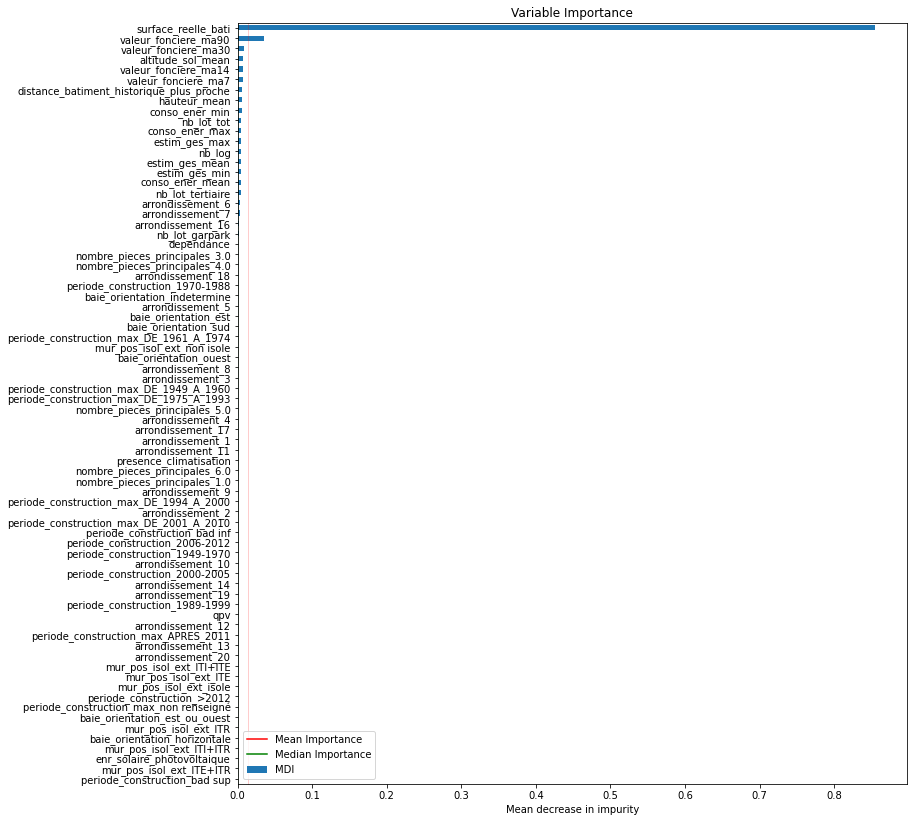

In [412]:
fig, ax = plt.subplots(figsize=(12, 14))

forest_importances.plot.barh(yerr=std, align="center", ax=ax, label="MDI")
sns.lineplot(
    x=[avg_importance, avg_importance], 
    y=[-1, len(forest_importances)], 
    ax=ax, 
    color="red", 
    label="Mean Importance")
sns.lineplot(
    x=[med_importance, med_importance], 
    y=[-1, len(forest_importances)], 
    ax=ax, color="green", 
    label="Median Importance")

ax.set_title("Variable Importance")
ax.set_xlabel("Mean decrease in impurity")

ax.legend(); 

### Mutual Information using `mutual_info_regression`

Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency. Based on the KL divergence. 

In [55]:
def get_mutual_info(X: np.ndarray, y: np.ndarray, n_neighbors: int=10) -> pd.Series: 
    """Description. Get mutual information for each feature."""

    mi = mutual_info_regression(
        X, 
        y, 
        discrete_features="auto", 
        n_neighbors=n_neighbors, 
        copy=True) 

    mi = pd.Series(mi, index=features).sort_values(ascending=False)
    return mi

In [56]:
mi = get_mutual_info(X_tr, y_tr)

In [57]:
from typing import Union, List

def select_important_features_mi(mi_values: Series, thresold: Union[str, float]="mean") -> List: 
    """Description. Select features with MI above thresold."""

    if thresold == "mean": 
        thresold = mi_values.mean()
    elif thresold == "median": 
        thresold = mi_values.median()
    elif thresold == "25%": 
        threshold = mi_values.quantile(.25)
    elif thresold == "75%":
        thresold = mi_values.quantile(.75)
    elif type(thresold) == float: 
        thresold = float(thresold)
    else: 
        raise ValueError("Thresold not recognized.")

    selected_features = mi_values[mi_values > thresold].index.tolist()

    return selected_features

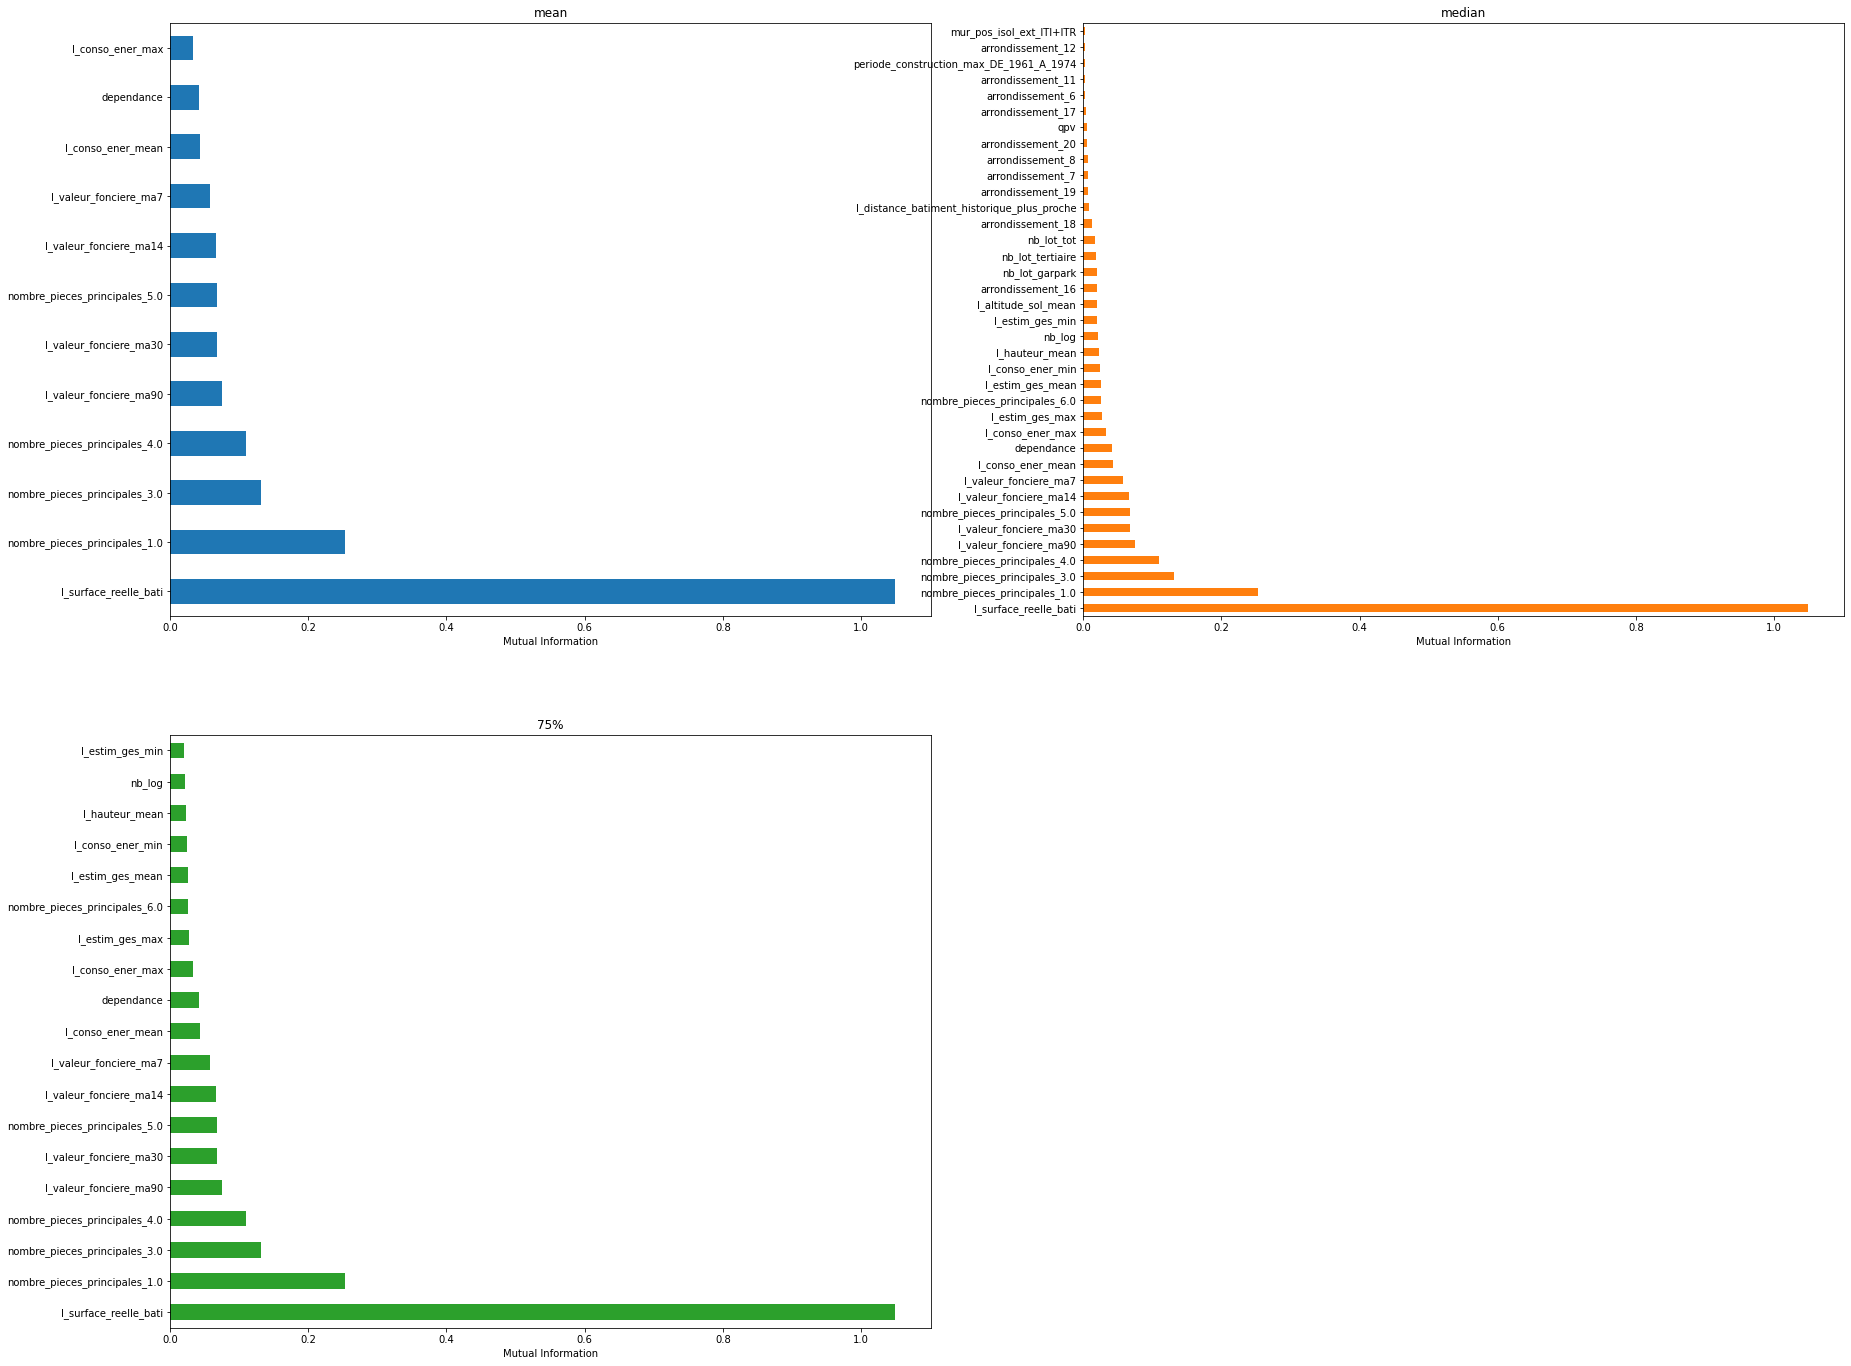

In [186]:
# plot mutual importances
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 24))
colors = sns.color_palette(n_colors=3)

for strategy, ax, color in zip(["mean", "median", "75%"], axes.flatten(), colors): 
    selected_features = select_important_features_mi(mi, thresold=strategy)
    mi[selected_features].plot.barh(ax=ax, color=color)
    ax.set_xlabel("Mutual Information")
    ax.set_title(strategy)
    
axes[-1, -1].axis("off"); 

### Modèle sur variables sélectionnées

In [58]:
selected_features = select_important_features_mi(mi, thresold="75%")
selected_features

['l_surface_reelle_bati',
 'nombre_pieces_principales_1.0',
 'nombre_pieces_principales_3.0',
 'nombre_pieces_principales_4.0',
 'l_valeur_fonciere_ma90',
 'nombre_pieces_principales_5.0',
 'l_valeur_fonciere_ma30',
 'l_valeur_fonciere_ma14',
 'l_valeur_fonciere_ma7',
 'l_conso_ener_mean',
 'dependance',
 'l_conso_ener_max',
 'l_estim_ges_max',
 'nombre_pieces_principales_6.0',
 'l_estim_ges_mean',
 'l_conso_ener_min',
 'l_hauteur_mean',
 'nb_log',
 'arrondissement_16']

In [218]:
X_tr2 = get_feature_vector(df_train, features=selected_features, return_df=False)
X_te2 = get_feature_vector(df_test, features=selected_features, return_df=False)

y_tr = get_target_vector(df_train, target=target, return_series=False)
y_te = get_target_vector(df_test, target=target, return_series=False)

In [59]:
assert X_tr2.shape[1] == X_te2.shape[1] == len(selected_features)

#### `XGBRegressor`

In [60]:
xgb = XGBRegressor()

help(xgb)

Help on XGBRegressor in module xgboost.sklearn object:

class XGBRegressor(XGBModel, sklearn.base.RegressorMixin)
 |  XGBRegressor(*, objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'reg:squarederror', **kwargs: Any) -> None
 |  
 |  Implementation of the scikit-learn API for XGBoost regression.
 |  
 |  
 |  Parameters
 |  ----------
 |  
 |      n_estimators : int
 |          Number of gradient boosted trees.  Equivalent to number of boosting
 |          rounds.
 |  
 |      max_depth :  Optional[int]
 |          Maximum tree depth for base learners.
 |      max_leaves :
 |          Maximum number of leaves; 0 indicates no limit.
 |      max_bin :
 |          If using histogram-based algorithm, maximum number of bins per feature
 |      grow_policy :
 |          Tree growing policy. 0: favor splitting at nodes closest to the node, i.e. grow
 |          depth-wise. 1: favor splitting at nodes with highest loss change.
 |

In [61]:
xgb.fit(X_tr2, y_tr)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [62]:
pred_tr = xgb.predict(X_tr2)
pred_te = xgb.predict(X_te2)

In [65]:
mape_tr = mean_absolute_percentage_error(y_tr, pred_tr)
mape_te = mean_absolute_percentage_error(y_te, pred_te)

print("Using log target variable")
print(f"\tXGB MAPE train: {round(100 * mape_tr, 2)}%")
print(f"\tXGB MAPE test: {round(100 * mape_te, 2)}%")

mape_tr = mean_absolute_percentage_error(get_price(y_tr), get_price(pred_tr)) 
mape_te = mean_absolute_percentage_error(get_price(y_te), get_price(pred_te)) 

print("Using target variable")
print(f"\tXGB MAPE train: {round(100 * mape_tr, 2)}%")
print(f"\tXGB MAPE test: {round(100 * mape_te, 2)}%")

Using log target variable
	XGB MAPE train: 1.08%
	XGB MAPE test: 1.16%
Using target variable
	XGB MAPE train: 14.27%
	XGB MAPE test: 15.5%


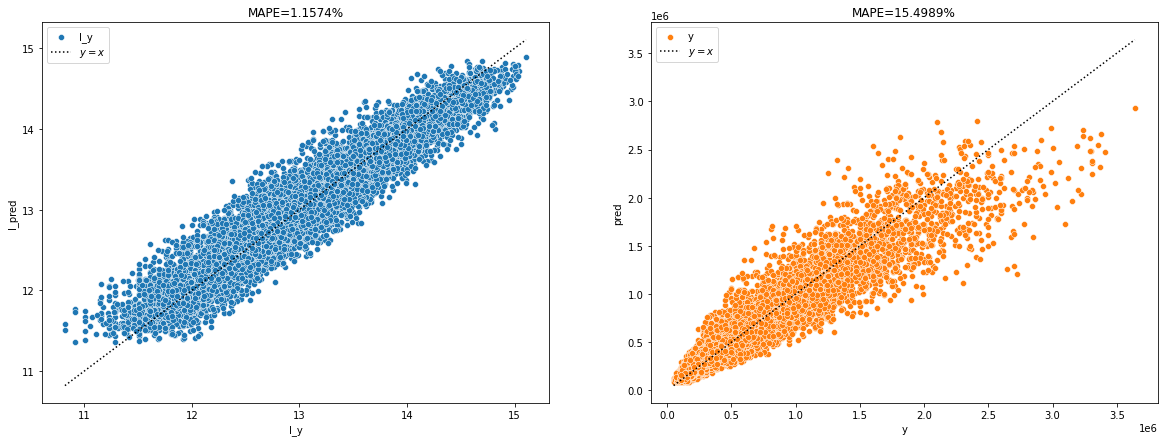

In [66]:
# make seaborn scatter plot of actual vs predicted with and without logarithm
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

tmp = pd.DataFrame(data={
    "l_y": y_te, 
    "l_pred": pred_te, 
    "y": get_price(y_te), 
    "pred": get_price(pred_te)
})

colors = sns.color_palette(n_colors=2)

for ax, target, pred, color in zip(axes.flatten(), ("l_y", "y"), ("l_pred", "pred"), colors): 
    sns.scatterplot(data=tmp, x=target, y=pred, color=color, ax=ax, label=target)

    min_x = tmp[target].min()
    max_x = tmp[target].max()

    sns.lineplot(
        x=[min_x, max_x], 
        y=[min_x, max_x], 
        label=r"$y=x$", 
        color="black", 
        linestyle="dotted", 
        ax=ax)

    ax.legend()

    mape = mean_absolute_percentage_error(tmp[target], tmp[pred])
    ax.set_title(f"MAPE={round(100 * mape, 4)}%")
    
del tmp; 

#### `RandomForestRegressor`

In [67]:
rf = RandomForestRegressor()

In [68]:
rf.fit(X_tr2, y_tr)

RandomForestRegressor()

In [69]:
pred_tr = rf.predict(X_tr2)
pred_te = rf.predict(X_te2)

In [74]:
pred_prices_tr = get_price(pred_tr)
pred_prices_te = get_price(pred_te)

prices_tr = get_price(y_tr)
prices_te = get_price(y_te)

In [75]:
mape_tr = mean_absolute_percentage_error(y_tr, pred_tr)
mape_te = mean_absolute_percentage_error(y_te, pred_te)

print("Using log target variable")
print(f"\tXGB MAPE train: {round(100 * mape_tr, 2)}%")
print(f"\tXGB MAPE test: {round(100 * mape_te, 2)}%")

mape_tr = mean_absolute_percentage_error(prices_tr, pred_prices_tr) 
mape_te = mean_absolute_percentage_error(prices_te, pred_prices_te) 

print("Using target variable")
print(f"\tXGB MAPE train: {round(100 * mape_tr, 2)}%")
print(f"\tXGB MAPE test: {round(100 * mape_te, 2)}%")

Using log target variable
	XGB MAPE train: 0.45%
	XGB MAPE test: 1.19%
Using target variable
	XGB MAPE train: 5.89%
	XGB MAPE test: 15.65%


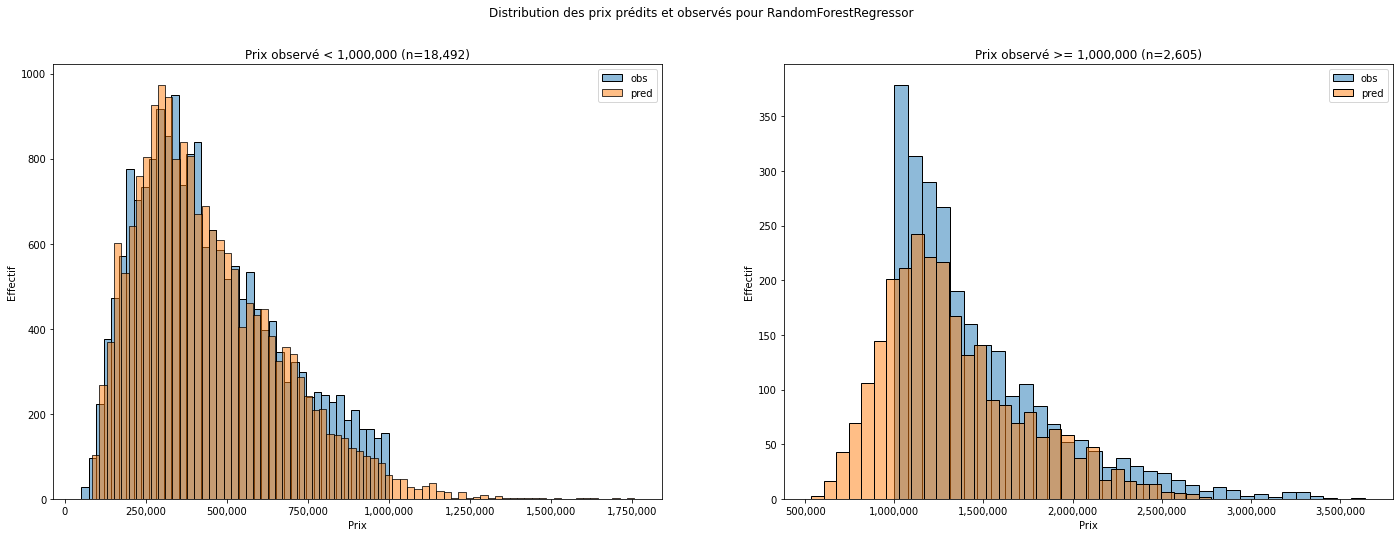

In [108]:
tmp = pd.DataFrame(data={
    "obs": prices_te,
    "pred": pred_prices_te
})

colors = sns.color_palette(n_colors=2)
thresold = 1e6

fig, axes = plt.subplots(ncols=2, figsize=(24, 8))
fig.suptitle("Distribution des prix prédits et observés pour RandomForestRegressor")

for sign, ax in zip(["<", ">="], axes.flatten()): 

    if sign == "<":
        tmp2 = tmp.loc[lambda x: x["obs"] < thresold]
    else:
        tmp2 = tmp.loc[lambda x: x["obs"] >= thresold]

    for color, var in zip(colors, ("obs", "pred")): 
        sns.histplot(
            data=tmp2, 
            x=var, 
            ax=ax, 
            label=var, 
            color=color, 
            alpha=.5)
        
    ax.legend()
    ax.set_xlabel("Prix")
    ax.set_ylabel("Effectif")
    ax.set_title(f"Prix observé {sign} {thresold:,.0f} (n={tmp2.shape[0]:,})")

    ax.get_xaxis().set_major_formatter(
        FuncFormatter(lambda x, p: format(int(x), ","))
    ); 

In [71]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=selected_features).sort_values()
forest_importances

nombre_pieces_principales_6.0    0.000062
nombre_pieces_principales_5.0    0.000174
nombre_pieces_principales_4.0    0.000342
nombre_pieces_principales_3.0    0.000935
dependance                       0.000997
nombre_pieces_principales_1.0    0.001007
arrondissement_16                0.001701
l_estim_ges_max                  0.007134
l_hauteur_mean                   0.007385
l_conso_ener_mean                0.007628
l_estim_ges_mean                 0.007710
l_conso_ener_max                 0.008104
l_conso_ener_min                 0.008567
l_valeur_fonciere_ma14           0.008892
l_valeur_fonciere_ma7            0.009309
l_valeur_fonciere_ma30           0.010240
nb_log                           0.010318
l_valeur_fonciere_ma90           0.034271
l_surface_reelle_bati            0.875223
dtype: float64

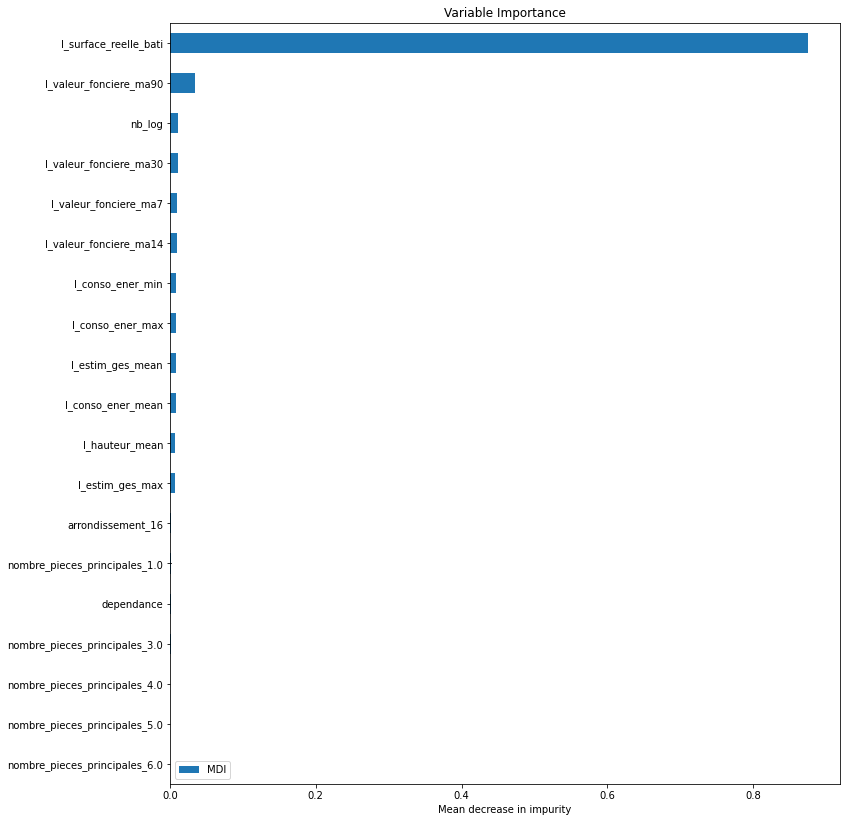

In [72]:
fig, ax = plt.subplots(figsize=(12, 14))

forest_importances.plot.barh(yerr=std, align="center", ax=ax, label="MDI")
ax.set_title("Variable Importance")
ax.set_xlabel("Mean decrease in impurity")

ax.legend(); 

### Sépration des biens par prix

On sépare les biens selon leur prix pour obtenir deux jeux de données `train`:
- `exp`: les biens ayant un prix supérieur à un certain seuil 
- `cheap`: les biens ayant un prix inférieur à un certain seuil

On effectue un modèle de régression pour les deux jeux de données. 

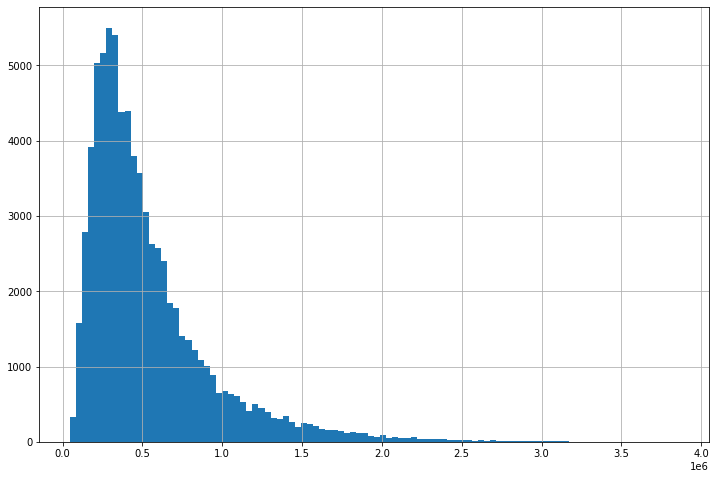

In [167]:
df_train\
    .l_valeur_fonciere\
    .apply(np.exp)\
    .hist(bins=100, figsize=(12, 8)); 

In [191]:
df_train\
    .l_valeur_fonciere\
    .quantile([.1, .25, .5, .75, .9])

0.10    12.142547
0.25    12.524526
0.50    12.955127
0.75    13.413539
0.90    13.860883
Name: l_valeur_fonciere, dtype: float64

In [194]:
from typing import Union

def get_thresold(prices: Union[pd.Series, np.ndarray], method: str) -> float: 

    if method == "median": 
        thresold = np.median(prices)
    elif method == "75%": 
        thresold = prices.quantile(.75)
    elif method == "90%":
        thresold = prices.quantile(.9)
    elif method == "95%":
        thresold = prices.quantile(.95)
    else:
        raise ValueError(f"Unknown method {method}")
        
    return thresold

def is_expensive(l_price: float, thresold: float) -> bool: 
    return l_price >= thresold

In [219]:
thresold = get_thresold(df_train.l_valeur_fonciere, method="75%")
print(thresold)

df_train_exp = df_train.loc[df_train["l_valeur_fonciere"].apply(lambda x: is_expensive(x, thresold)), :]
df_train_cheap = df_train.loc[~df_train["l_valeur_fonciere"].apply(lambda x: is_expensive(x, thresold)), :]

df_test_exp = df_test.loc[df_test["l_valeur_fonciere"].apply(lambda x: is_expensive(x, thresold)), :]
df_test_cheap = df_test.loc[~df_test["l_valeur_fonciere"].apply(lambda x: is_expensive(x, thresold)), :]

13.413539339110365


In [199]:
df_train_exp.shape, df_train_cheap.shape

((19054, 75), (57145, 75))

In [220]:
X_tr = {
    "exp": get_feature_vector(df_train_exp, features=selected_features, return_df=False), 
    "cheap": get_feature_vector(df_train_cheap, features=selected_features, return_df=False)
} 

y_tr = {
    "exp": get_target_vector(df_train_exp, target="l_valeur_fonciere"),
    "cheap": get_target_vector(df_train_cheap, target="l_valeur_fonciere")
}

#### Entrainement de 2 `RandomForestRegressor` 

In [202]:
rf = {
    type: RandomForestRegressor()
    for type in ("exp", "cheap")
}

loop = tqdm(rf.keys()) 
for type in loop: 
    loop.set_description(f"Fitting {type}")
    rf[type].fit(X_tr[type], y_tr[type])

Fitting cheap: 100%|██████████| 2/2 [02:12<00:00, 66.41s/it]


#### Diagnostic train

In [221]:
pred_tr = {
    type: rf[type].predict(X_tr[type]) 
    for type in ("exp", "cheap")
}

pred_prices_tr = {
    type: get_price(pred_tr[type])
    for type in ("exp", "cheap")
} 

prices_tr = {
    type: get_price(y_tr[type])
    for type in ("exp", "cheap")
} 

In [222]:
mape_tr = {
    type: mean_absolute_percentage_error(y_tr[type], pred_tr[type])
    for type in ("exp", "cheap")
} 

print("Using log target variable")
for type in ("exp", "cheap"):
    print(f"\tXGB MAPE train ({type}): {round(100 * mape_tr[type], 2)}%")

mape_tr_prices = {
    type: mean_absolute_percentage_error(prices_tr[type], pred_prices_tr[type])
    for type in ("exp", "cheap")
} 

print("Using target variable")
for type in ("exp", "cheap"):
    print(f"\tXGB MAPE train ({type}): {round(100 * mape_tr_prices[type], 2)}%")

Using log target variable
	XGB MAPE train (exp): 0.34%
	XGB MAPE train (cheap): 0.45%
Using target variable
	XGB MAPE train (exp): 4.69%
	XGB MAPE train (cheap): 5.68%


#### Prédiction en test par modèle (approche naïve)

In [223]:
pred_te = {
    type: rf[type].predict(X_te2) 
    for type in ("exp", "cheap")
}

pred_prices_te = {
    type: get_price(pred_te[type])
    for type in ("exp", "cheap")
} 

In [226]:
prices_te = get_price(y_te)

In [227]:
mape_te = {
    type: mean_absolute_percentage_error(y_te, pred_te[type])
    for type in ("exp", "cheap")
} 

print("Using log target variable")
for type in ("exp", "cheap"):
    print(f"\tXGB MAPE test using {type} model: {round(100 * mape_te[type], 2)}%")

mape_te_prices = {
    type: mean_absolute_percentage_error(prices_te, pred_prices_te[type])
    for type in ("exp", "cheap")
} 

print("Using target variable")
for type in ("exp", "cheap"):
    print(f"\tXGB MAPE test using {type} model: {round(100 * mape_te_prices[type], 2)}%")

Using log target variable
	XGB MAPE test using exp model: 4.87%
	XGB MAPE test using cheap model: 2.06%
Using target variable
	XGB MAPE test using exp model: 109.94%
	XGB MAPE test using cheap model: 22.77%


#### Approche optimale

Impossible en réalité car on ne connait pas le prix des biens !

In [228]:
X_te = {
    "exp": get_feature_vector(df_test_exp, features=selected_features, return_df=False), 
    "cheap": get_feature_vector(df_test_cheap, features=selected_features, return_df=False)
} 

y_te = {
    "exp": get_target_vector(df_test_exp, target="l_valeur_fonciere"),
    "cheap": get_target_vector(df_test_cheap, target="l_valeur_fonciere")
}

In [229]:
pred_te = {
    type: rf[type].predict(X_te[type]) 
    for type in ("exp", "cheap")
}

pred_prices_te = {
    type: get_price(pred_te[type])
    for type in ("exp", "cheap")
} 

prices_te= {
    type: get_price(y_te[type])
    for type in ("exp", "cheap")
} 

In [230]:
mape_te = {
    type: mean_absolute_percentage_error(y_te[type], pred_te[type])
    for type in ("exp", "cheap")
} 

print("Using log target variable")
for type in ("exp", "cheap"):
    print(f"\tXGB MAPE test ({type}): {round(100 * mape_te[type], 2)}%")

mape_te_prices = {
    type: mean_absolute_percentage_error(prices_te[type], pred_prices_te[type])
    for type in ("exp", "cheap")
} 

print("Using target variable")
for type in ("exp", "cheap"):
    print(f"\tXGB MAPE test ({type}): {round(100 * mape_te_prices[type], 2)}%")

Using log target variable
	XGB MAPE test (exp): 0.9%
	XGB MAPE test (cheap): 1.17%
Using target variable
	XGB MAPE test (exp): 12.48%
	XGB MAPE test (cheap): 15.07%


#### Prédiction d'un nouveau point

Sans connaissance du prix. 

In [155]:
# implement the Hamming distance
def hamming_distance(x1: np.ndarray, x2: np.ndarray) -> float:
    return np.mean(x1 != x2)

# implement euclidean distance
def euclidean_distance(x1: np.ndarray, x2: np.ndarray) -> float:
    return np.sqrt(np.sum((x1 - x2)**2))

# implement custom distance as average between hamming and euclidean distance
# hamming distance is applied to dummy variables
# euclidean distance is applied to continuous variables

# implement function which check if numpy column is made of 0 or 1
def is_dummy(x: np.ndarray) -> bool:
    return np.all(np.isin(x, [0, 1]))

# function to extract all dummy columns in numpy array
def get_dummy_columns(X: np.ndarray) -> List:
    p = X.shape[1]
    return [j for j in range(p) if is_dummy(X[:, j])]

# function which apply custom distance to numpy array
# hamming distance for dummy variables
# euclidean distance for continuous variables
# return mean distance between two numpy arrays
def custom_distance(X: np.ndarray, x: np.ndarray) -> float:

    p1, p2 = X.shape[1], x.shape[0]
    if p1 != p2:
        raise ValueError("x1 and x2 must have the same number of columns")
    
    dummy_columns = get_dummy_columns(X)
    quant_columns = [j for j in range(p1) if j not in dummy_columns]

    hamming_dist = hamming_distance(X[:, dummy_columns], x[dummy_columns])
    euclidean_dist = euclidean_distance(X[:, quant_columns], x[quant_columns])

    dist = np.mean([hamming_dist, euclidean_dist])
    return dist

# apply custom_distance between X_tr["exp"] and all points in X_te2
dists = [custom_distance(X_tr["exp"], x) for x in X_te2]
dists

[4177.413225224709,
 4704.710017348216,
 4511.667733723013,
 4168.602012235964,
 4430.919344010266,
 4370.101353946581,
 4103.3536918279315,
 5755.528136178925,
 4532.494480105037,
 17210.1456020568,
 4124.98790829018,
 4034.3641600379497,
 4510.26084454598,
 4010.3848862816703,
 4162.174792881694,
 4369.744606801079,
 4298.741690559692,
 4087.0058997443907,
 4015.5630607393414,
 4072.9589167788968,
 4490.277576618468,
 4005.9177903378827,
 3990.4645858855,
 4056.1419150949478,
 4149.654096902816,
 4007.138059585113,
 4107.735826573938,
 4249.317243904719,
 20038.10025519543,
 4264.9171498645455,
 4203.16955113421,
 4249.591255641113,
 6199.77354023963,
 4448.227964014009,
 4281.304864015533,
 6306.00392198791,
 4162.109147326278,
 4320.2597448747065,
 4264.7775462970185,
 4248.990659710282,
 4010.76388857636,
 5190.608344766209,
 4333.951411134966,
 4138.9191829242745,
 4315.511807578423,
 4204.231770564028,
 4072.5259995577944,
 3991.719429325021,
 9695.295497234012,
 4599.7731367039

## Optimisation via `optuna`

Le matrice des features se compose des variables sélectionnées via la méthode `mutual_info_regression`. 

In [59]:
import sqlalchemy
from optuna import Trial, create_study

In [60]:
from multiprocessing import cpu_count 
CPU_COUNT = cpu_count()
CPU_COUNT

8

In [61]:
X_tr = get_feature_vector(df_train, features=selected_features, return_df=False)
y_tr = get_target_vector(df_train, target="l_valeur_fonciere", return_series=False)

X_te = get_feature_vector(df_test, features=selected_features, return_df=False)
y_te = get_target_vector(df_test, target="l_valeur_fonciere", return_series=False)

In [62]:
from typing import Union

def get_price(y: Union[float, np.ndarray]) -> Union[float, np.ndarray]: 
    """Description. Remove logarithm to get predicted price."""

    return np.exp(y)

In [63]:
def objective_xgb(
        trial: Trial, 
        X_tr: np.ndarray, 
        y_tr: np.ndarray, 
        X_te: np.ndarray, 
        y_te: np.ndarray
    ) -> float:
    """Description.
    Objective function to otpimize XGBRegressor hyperparameters.

    Args:
        trial (Trial): optuna trial
        X_tr (np.ndarray): training features
        y_tr (np.ndarray): training target
        X_te (np.ndarray): test features
        y_te (np.ndarray): test target

    Returns: MAPE between predicted prices and real prices on test set.
    
    Details: target variable is the logarithm of the price (l_valeur_fonciere)."""

    # define the hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.5)
    gamma = trial.suggest_uniform("gamma", 0.01, 0.5)
    reg_lambda = trial.suggest_uniform("reg_lambda", 0.01, 0.5)
    reg_alpha = trial.suggest_uniform("reg_alpha", 0.01, 0.5)

    # define the model
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        random_state=0
    )

    # fit the model
    model.fit(X_tr, y_tr)

    # predict the target variable
    pred = model.predict(X_te)

    # retrieve prices
    prices = get_price(y_te)
    pred_prices = get_price(pred)

    # compute the mape
    mape = mean_absolute_percentage_error(prices, pred_prices)

    return mape

In [66]:
# create the study
study = create_study(direction="minimize")

# optimize the hyperparameters
study.optimize(
    lambda trial: objective_xgb(trial, X_tr, y_tr, X_te, y_te),
    n_trials=20,
    n_jobs=CPU_COUNT-2,
    gc_after_trial=True, 
    show_progress_bar=True
)

[I 2023-03-28 17:01:34,181] A new study created in memory with name: no-name-5f792242-e248-49dc-ba6e-b249ca82174d
c:\Users\pemma\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_lambda = trial.suggest_unifo

[I 2023-03-28 17:02:21,481] Trial 1 finished with value: 0.15559238392408178 and parameters: {'n_estimators': 285, 'max_depth': 3, 'learning_rate': 0.300020907858521, 'gamma': 0.3951211820024587, 'reg_lambda': 0.1610029312761373, 'reg_alpha': 0.07365989458224448}. Best is trial 1 with value: 0.15559238392408178.


C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_lambda = trial.suggest_unifo

[I 2023-03-28 17:03:32,603] Trial 6 finished with value: 0.1547812179228622 and parameters: {'n_estimators': 545, 'max_depth': 3, 'learning_rate': 0.1554040548158562, 'gamma': 0.22253091557354474, 'reg_lambda': 0.42613608584916146, 'reg_alpha': 0.26126416751400283}. Best is trial 6 with value: 0.1547812179228622.


C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_lambda = trial.suggest_unifo

[I 2023-03-28 17:03:56,150] Trial 7 finished with value: 0.7212123316653004 and parameters: {'n_estimators': 179, 'max_depth': 3, 'learning_rate': 0.012691634937189805, 'gamma': 0.16329379819090498, 'reg_lambda': 0.4973982251824015, 'reg_alpha': 0.48057191081281597}. Best is trial 6 with value: 0.1547812179228622.


C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_lambda = trial.suggest_unifo

[I 2023-03-28 17:04:05,551] Trial 2 finished with value: 0.15303029226743695 and parameters: {'n_estimators': 217, 'max_depth': 9, 'learning_rate': 0.15397616164583366, 'gamma': 0.23665116292441904, 'reg_lambda': 0.19023553828054485, 'reg_alpha': 0.3896131811532659}. Best is trial 2 with value: 0.15303029226743695.


C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_lambda = trial.suggest_unifo

[I 2023-03-28 17:04:41,709] Trial 5 finished with value: 0.15532364591511216 and parameters: {'n_estimators': 909, 'max_depth': 4, 'learning_rate': 0.33262215311522103, 'gamma': 0.22462675025083434, 'reg_lambda': 0.18765846765787933, 'reg_alpha': 0.4205024252854827}. Best is trial 2 with value: 0.15303029226743695.


C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_lambda = trial.suggest_unifo

[I 2023-03-28 17:04:55,210] Trial 9 finished with value: 0.15506625761982737 and parameters: {'n_estimators': 340, 'max_depth': 3, 'learning_rate': 0.17269002351497906, 'gamma': 0.29116447488695557, 'reg_lambda': 0.4161615384815705, 'reg_alpha': 0.10242769595958355}. Best is trial 2 with value: 0.15303029226743695.


C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_lambda = trial.suggest_unifo

[I 2023-03-28 17:05:10,760] Trial 4 finished with value: 0.1571773707602538 and parameters: {'n_estimators': 732, 'max_depth': 5, 'learning_rate': 0.46861209430419404, 'gamma': 0.44070778420226125, 'reg_lambda': 0.4938081914162234, 'reg_alpha': 0.26613889424953535}. Best is trial 2 with value: 0.15303029226743695.


C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_lambda = trial.suggest_unifo

[I 2023-03-28 17:05:28,099] Trial 8 finished with value: 0.15459904627198076 and parameters: {'n_estimators': 147, 'max_depth': 9, 'learning_rate': 0.22747539179450343, 'gamma': 0.3539647199648401, 'reg_lambda': 0.36833124611034795, 'reg_alpha': 0.10870578955190562}. Best is trial 2 with value: 0.15303029226743695.


C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_lambda = trial.suggest_unifo

[I 2023-03-28 17:06:07,442] Trial 10 finished with value: 0.1540138039647718 and parameters: {'n_estimators': 340, 'max_depth': 5, 'learning_rate': 0.12030884558915692, 'gamma': 0.2845274029586666, 'reg_lambda': 0.482713774958961, 'reg_alpha': 0.4947791726470892}. Best is trial 2 with value: 0.15303029226743695.


C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_lambda = trial.suggest_unifo

[I 2023-03-28 17:06:34,863] Trial 13 finished with value: 0.15546193915769196 and parameters: {'n_estimators': 101, 'max_depth': 9, 'learning_rate': 0.32222640419033016, 'gamma': 0.48809375054824056, 'reg_lambda': 0.32377081904866606, 'reg_alpha': 0.13598566782663557}. Best is trial 2 with value: 0.15303029226743695.


C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_lambda = trial.suggest_unifo

[I 2023-03-28 17:06:59,272] Trial 3 finished with value: 0.15372457670074166 and parameters: {'n_estimators': 984, 'max_depth': 6, 'learning_rate': 0.15485470129394355, 'gamma': 0.16898035957851404, 'reg_lambda': 0.3462492877263293, 'reg_alpha': 0.09552427445116085}. Best is trial 2 with value: 0.15303029226743695.


C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_lambda = trial.suggest_unifo

[I 2023-03-28 17:07:04,583] Trial 12 finished with value: 0.15468520820113582 and parameters: {'n_estimators': 585, 'max_depth': 4, 'learning_rate': 0.18914781340407905, 'gamma': 0.24164623879448807, 'reg_lambda': 0.07244668251038937, 'reg_alpha': 0.2691262823196412}. Best is trial 2 with value: 0.15303029226743695.


C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_lambda = trial.suggest_unifo

[I 2023-03-28 17:07:17,988] Trial 0 finished with value: 0.15423044627531587 and parameters: {'n_estimators': 490, 'max_depth': 9, 'learning_rate': 0.27598479622965133, 'gamma': 0.29626275440009797, 'reg_lambda': 0.27829222525003433, 'reg_alpha': 0.29013694643987925}. Best is trial 2 with value: 0.15303029226743695.


C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_lambda = trial.suggest_unifo

[I 2023-03-28 17:10:37,012] Trial 15 finished with value: 0.16637355552908456 and parameters: {'n_estimators': 533, 'max_depth': 7, 'learning_rate': 0.4379448361020137, 'gamma': 0.016364807191903558, 'reg_lambda': 0.026352240872070637, 'reg_alpha': 0.3588583901893221}. Best is trial 2 with value: 0.15303029226743695.


C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.01, 0.5)
C:\Users\pemma\AppData\Local\Temp/ipykernel_8852/2099483390.py:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg_lambda = trial.suggest_unifo

[I 2023-03-28 17:11:16,802] Trial 16 finished with value: 0.15198540435750246 and parameters: {'n_estimators': 583, 'max_depth': 7, 'learning_rate': 0.05543096391630732, 'gamma': 0.014788535417877419, 'reg_lambda': 0.05443221493891659, 'reg_alpha': 0.3597610418653328}. Best is trial 16 with value: 0.15198540435750246.
[I 2023-03-28 17:11:52,163] Trial 11 finished with value: 0.15361586357675833 and parameters: {'n_estimators': 792, 'max_depth': 8, 'learning_rate': 0.1012718451008537, 'gamma': 0.38526225355836796, 'reg_lambda': 0.252556732978112, 'reg_alpha': 0.1315403865394165}. Best is trial 16 with value: 0.15198540435750246.
[I 2023-03-28 17:12:16,689] Trial 14 finished with value: 0.15973873826019103 and parameters: {'n_estimators': 564, 'max_depth': 10, 'learning_rate': 0.35210047960508933, 'gamma': 0.14107517528927263, 'reg_lambda': 0.3114171317864296, 'reg_alpha': 0.06055982801912615}. Best is trial 16 with value: 0.15198540435750246.
[I 2023-03-28 17:13:08,823] Trial 17 finishe

In [68]:
study.best_trial

FrozenTrial(number=19, values=[0.15166540945881], datetime_start=datetime.datetime(2023, 3, 28, 17, 10, 37, 192656), datetime_complete=datetime.datetime(2023, 3, 28, 17, 13, 53, 554063), params={'n_estimators': 999, 'max_depth': 7, 'learning_rate': 0.07680122746435507, 'gamma': 0.09732284022175444, 'reg_lambda': 0.19842343518323083, 'reg_alpha': 0.16775744269280204}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.5, log=False, low=0.01, step=None), 'gamma': FloatDistribution(high=0.5, log=False, low=0.01, step=None), 'reg_lambda': FloatDistribution(high=0.5, log=False, low=0.01, step=None), 'reg_alpha': FloatDistribution(high=0.5, log=False, low=0.01, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=19, state=TrialState.COMPLETE, value=None)